In [1]:
# Basic imports
import os
import sys
import pickle
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')
sys.path.insert(0, './src')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from missforest import MissForest

# Statistic imports
from scipy.special import kl_div
from scipy.stats import ks_2samp, entropy, wasserstein_distance

# Custom modules
from src.gain import *
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cmap import Colormap

# Ignore warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
dict_select = data["dict_select"]

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

# List Imputers

In [3]:
random_state=42
n_imputation_iter = 100

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_3", KNNImputer(n_neighbors=3)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(continuous_imputer)
    print(ordinal_imputer)
    print(model)
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

('SimpleImputer_mean', SimpleImputer())
('SimpleImputer_most_frequent', SimpleImputer(strategy='most_frequent'))
('LinearRegression', LinearRegression())
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
('SimpleImputer_mean', SimpleImputer())
('SimpleImputer_most_frequent', SimpleImputer(strategy='most_frequent'))
('PLSRegression_4_components', PLSRegression(n_components=4))
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_4_components
('SimpleImputer_mean', SimpleImputer())
('KNNImputer', KNNImputer(n_neighbors=1))
('LinearRegression', LinearRegression())
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
('SimpleImputer_mean', SimpleImputer())
('KNNImputer', KNNImputer(n_neighbors=1))
('PLSRegression_4_components', PLSRegression(n_components=4))
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: PLSRe

# Compute imputed data distributions

In order to have a look at the features imputed by our different algorithms, we will just impute some of the data with the different algorithms on the training set with all the missing values to see if the distributions of imputed data do not diverge too much from the original ones. 

In [4]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [5]:
df_X_imputed_list = {"Original" : df_X_train}

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

imputed_filename = "dict_imputed_df_X"

file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

if os.path.exists(file_path):
    print(f"The file '{imputed_filename}' already exists'.")
    with open(file_path, "rb") as file: 
        df_X_imputed_list = pd.read_pickle(file)
else:

    for imputer_name, continuous_imputer in continuous_imputer_list: 
        df_X_imputed = df_X_train.copy()

        continuous_imputer.fit(df_X_train[continuous_features])
        
        df_X_imputed[continuous_features] = continuous_imputer.transform(df_X_train[continuous_features])
        df_X_imputed_list[imputer_name] = df_X_imputed

    file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

    with open(file_path, 'wb') as file:
        pickle.dump(df_X_imputed_list, file)
    print(f"The dictionary has been saved as '{imputed_filename}.pkl' in the folder ''.")

The file 'dict_imputed_df_X' already exists'.


In [6]:
cols_to_check = ['ABETA', 'TAU', 'PTAU', 'CREB5', 'CLIC1', 'CD63']

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())

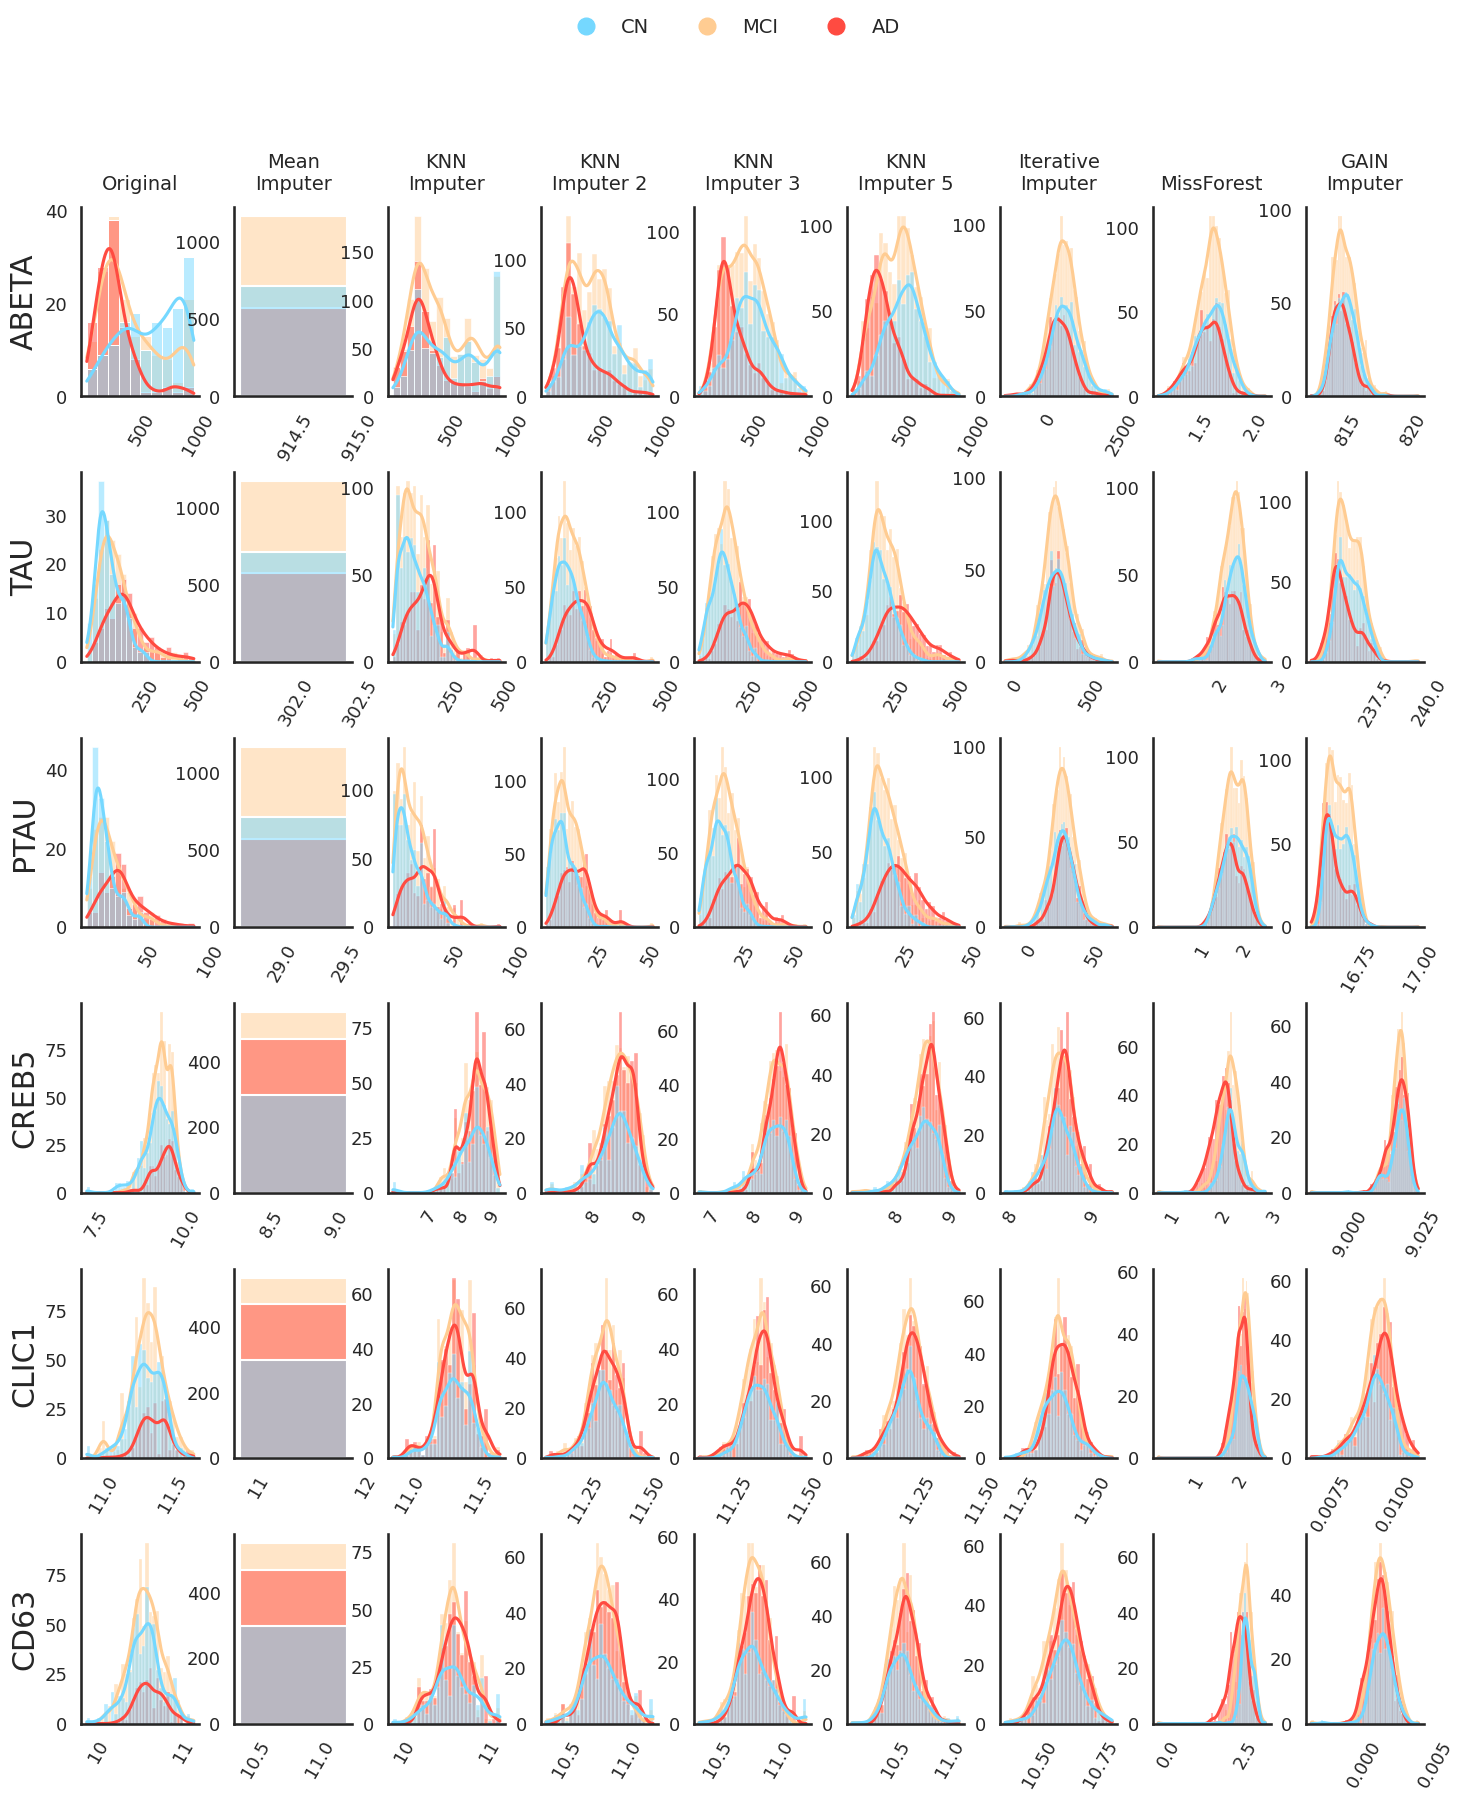

In [7]:
hue_col = df_all.DX[idx_train]
palette = dx_palette

sns.set_style("white")
sns.set_context("talk")

df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=len(imputed_X_lst), figsize=(15, 18))
axes = np.array(axes)

original_ticks = {}

for i, plot_X in enumerate(imputed_X_lst):
    for j, col in enumerate(cols_to_check):
        if imputed_name_lst[i] != "Original":
            plot_X_filtered = plot_X[df_X0[col].isna()]
        else:
            plot_X_filtered = plot_X
            original_ticks[col] = [
                np.floor(plot_X[col].min()),
                np.floor((plot_X[col].min() + plot_X[col].max()) / 2),
                np.ceil(plot_X[col].max()),
            ]

        sns.histplot(
            plot_X_filtered,
            x=col,
            hue=hue_col,
            ax=axes[j][i],
            palette=palette,
            kde=(imputed_name_lst[i] != "SimpleImputer_mean"),
            legend=False,
        )

        axes[j][i].set_xlabel("")
        axes[j][i].set_ylabel("")
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha="left", fontsize=13)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha="right", fontsize=13)
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=1)
        sns.despine()

# Set column titles with proper spacing
for ax, col in zip(axes[0], imputed_name_lst):
    ax.set_title(
        col.replace("SimpleImputer_mean", "MeanImputer")
           .replace("_", " ")
           .replace("Imputer", "\nImputer")
           .replace("(", "\n("),
        pad=12,  # Add padding above titles
        fontsize=14
    )

# Set row labels
for ax, col in zip(axes[:, 0], cols_to_check):
    ax.set_ylabel(col.replace("_", " "), rotation=90, size="large")

# Legend (centered above)
if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker="o", linestyle="", markersize=12, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.01),  # Bring legend closer
        ncol=len(palette),
        frameon=False,
        fontsize=14
    )

# Reduce space between plots and legend
plt.tight_layout(rect=[0, 0, 1, 0.94])  # Reserve top space for legend
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Save
plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches="tight")
plt.show()


In [8]:
df_X_imputed_list
features_of_interest=cols_to_check
savefolder = "../figures/imputation"
heatmap_annot=True

original_df = df_X_imputed_list['Original']
ks_stats = {}
p_values = {}
kl_divergences = {}

In [9]:
def compute_imputation_stats(original_df, df_X_imputed_list, features_of_interest):
    ks_stats = {}
    p_values = {}
    kl_divergences = {}
    entropies = {}
    wasserstein_distances = {}
    ecdf_data_dict = {}

    for feature_name in features_of_interest:
        ks_stats[feature_name] = {}
        p_values[feature_name] = {}
        kl_divergences[feature_name] = {}
        entropies[feature_name] = {}
        wasserstein_distances[feature_name] = {}

        # Clean original (non-missing values)
        original_clean = original_df[feature_name].dropna()
        missing_indices = original_df[feature_name].isna()

        # Common histogram bins based on original
        bins = np.histogram_bin_edges(original_clean, bins="fd")

        # Histogram for original
        original_hist, _ = np.histogram(original_clean, bins=bins, density=True)
        original_hist += 1e-9  # smoothing
        original_hist /= original_hist.sum()  # normalize


        # ECDF container
        ecdf_data = pd.DataFrame()

        for method, imputed_df in df_X_imputed_list.items():
            if method == 'Original':
                continue

            imputed_values = imputed_df.loc[missing_indices, feature_name].dropna()

            # KS test
            ks_stat, p_value = ks_2samp(original_clean, imputed_values)
            ks_stats[feature_name][method] = ks_stat
            p_values[feature_name][method] = p_value

            # Histogram for imputed values
            imputed_hist, _ = np.histogram(imputed_values, bins=bins, density=True)
            imputed_hist += 1e-9
            imputed_hist /= imputed_hist.sum()

            # KL divergence
            kl_divergences[feature_name][method] = entropy(original_hist, imputed_hist, base=2, nan_policy='omit')

            # Wasserstein distance (directly on raw values)
            print(f"Calculating Wasserstein distance for {feature_name} using method {method}")
            print(original_clean.shape, imputed_values.shape)

            w_distance = wasserstein_distance(original_clean, imputed_values)
            wasserstein_distances[feature_name][method] = w_distance

            # ECDF
            temp_df = pd.DataFrame({
                'Value': np.sort(imputed_values),
                'ECDF': np.arange(len(imputed_values)) / len(imputed_values),
                'Method': method
            })
            ecdf_data = pd.concat([ecdf_data, temp_df], ignore_index=True)

        # ECDF for original
        original_ecdf = pd.DataFrame({
            'Value': np.sort(original_clean),
            'ECDF': np.arange(len(original_clean)) / len(original_clean),
            'Method': 'Original'
        })
        ecdf_data = pd.concat([ecdf_data, original_ecdf], ignore_index=True)

        ecdf_data_dict[feature_name] = ecdf_data

    return (
        ecdf_data_dict,
        ks_stats,
        p_values,
        kl_divergences,
        wasserstein_distances
    )

In [10]:
select_imputed_features = dict_select["RNA"]+dict_select["CSF"]
# Compute all ECDFs and stats
ecdf_data_dict, ks_stats, p_values, kl_divs,  wasserstein = compute_imputation_stats(original_df, df_X_imputed_list, select_imputed_features)

Calculating Wasserstein distance for NSMAF using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method KNNImputer_2
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method KNNImputer_3
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method KNNImputer_5
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method IterativeImputer
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method MissForest
(1563,) (1318,)
Calculating Wasserstein distance for NSMAF using method GAINImputer
(1563,) (1318,)
Calculating Wasserstein distance for FLT3 using method SimpleImputer_mean
(1563,) (1318,)
Calculating Wasserstein distance for FLT3 using method KNNImputer
(1563,) (1318,)
Calculating Wasserstein distance for FLT3 using method KNNImputer_2
(1563,) (1318,)
Calculating Wasserstein distance for FLT3 using method KNNI

In [11]:
def plot_ecdf_grid(ecdf_data_dict, features_of_interest, savefolder=None):

    sns.set_style("white")
    sns.set_context("talk")

    selected_features = [f for f in features_of_interest if f in ecdf_data_dict]
    num_features = len(selected_features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 4))
    axes = axes.flatten()

    for i, feature_name in enumerate(selected_features):
        ecdf_data = ecdf_data_dict[feature_name]

        sns.lineplot(
            data=ecdf_data,
            x="Value",
            y="ECDF",
            hue="Method",
            ax=axes[i],
            palette=sns.color_palette("Set1"),
            linewidth=3,
            alpha=0.8
        )

        axes[i].set_title(feature_name)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('ECDF')
        axes[i].get_legend().remove()
        sns.despine()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Global legend
    handles, labels = axes[0].get_legend_handles_labels()
    labels = [l.replace("SimpleImputer_mean", "MeanImputer")
                .replace("Imputer", " Imputer")
                .replace("_", " ")
                .replace("(", " (") for l in labels]

    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=min(len(labels), 4),
        title="Imputation Method",
        frameon=False,
        fontsize=16,
        title_fontsize=18
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.85])

    if savefolder is not None:
        plt.savefig(f"{savefolder}_ecdf_plot.png", format="png", bbox_inches='tight')

    plt.show()


In [12]:
def plot_metric_heatmap(
    metric_df,
    metric_name,
    df_select_features=None,  # NEW: for grouping features by source
    features_of_interest=None,
    annotations_df=None,
    savefolder=None,
    cmap="vlag",
    vmin=None,
    vmax=None,
    cbar_ticks=None,
    figsize=(14, 6),
    dpi=300,
    font_scale=1.2,
    annot_format_func=None
):
    """
    Plots a high-quality heatmap for a given metric, with features grouped and sorted by domain and metric mean.
    """

    # Extract feature grouping if provided
    if df_select_features is not None:
        grouped_sorted_features = []

        # Convert to dict: {source: [features]}
        grouped_features = df_select_features.to_dict(orient='list')
        grouped_features = {k: [f for f in v if f in metric_df.index] for k, v in grouped_features.items()}

        # Sort within each group by average metric value across methods
        for source, features in grouped_features.items():
            feature_means = metric_df.loc[features].mean(axis=1)
            sorted_features = feature_means.sort_values(ascending=False).index.tolist()
            grouped_sorted_features.extend(sorted_features)

        metric_df = metric_df.loc[grouped_sorted_features]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[grouped_sorted_features]

    # Optionally subset features
    elif features_of_interest is not None:
        metric_df = metric_df.loc[features_of_interest]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[features_of_interest]

    # Sort imputation methods (rows) by mean metric value (descending)
    method_means = metric_df.mean(axis=1).sort_values(ascending=False)
    metric_df = metric_df.loc[method_means.index]
    if annotations_df is not None:
        annotations_df = annotations_df.loc[method_means.index]

    # Format annotations
    if annotations_df is not None and annot_format_func is not None:
        annotations_df = annotations_df.applymap(annot_format_func)

    # Set styles
    sns.set_context("talk", font_scale=font_scale)
    sns.set_style("white")

    # Plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.heatmap(
        metric_df,
        annot=annotations_df if annotations_df is not None else None,
        fmt="" if annotations_df is None else ".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="lightgrey",
        square=False,
        cbar_kws={'label': metric_name, 'ticks': cbar_ticks} if cbar_ticks else {'label': metric_name},
        ax=ax
    )

    # Clean y-tick labels (methods)
    ax.set_yticklabels([
        label.get_text()
        .replace("SimpleImputer_mean", "Mean Imputer")
        .replace("IterativeImputer", "Iterative Imputer")
        .replace("KNNImputer", "KNN Imputer")
        .replace("MissForest", "MissForest")
        .replace("Imputer", " Imputer")
        .replace("_", " ")
        for label in ax.get_yticklabels()
    ], rotation=0, fontsize=12)

    # Clean x-tick labels (features)
    ax.set_xticklabels([
        label.get_text().replace("_", " ") for label in ax.get_xticklabels()
    ], rotation=45, ha='right', fontsize=12)

    ax.set_ylabel("Imputation Method", fontsize=14)
    ax.set_xlabel("Feature", fontsize=14)
    plt.tight_layout()

    # Save
    if savefolder is not None:
        fname = f"{savefolder}_{metric_name.lower().replace(' ', '_')}_heatmap.png"
        plt.savefig(fname, bbox_inches="tight", format="png")

    plt.show()


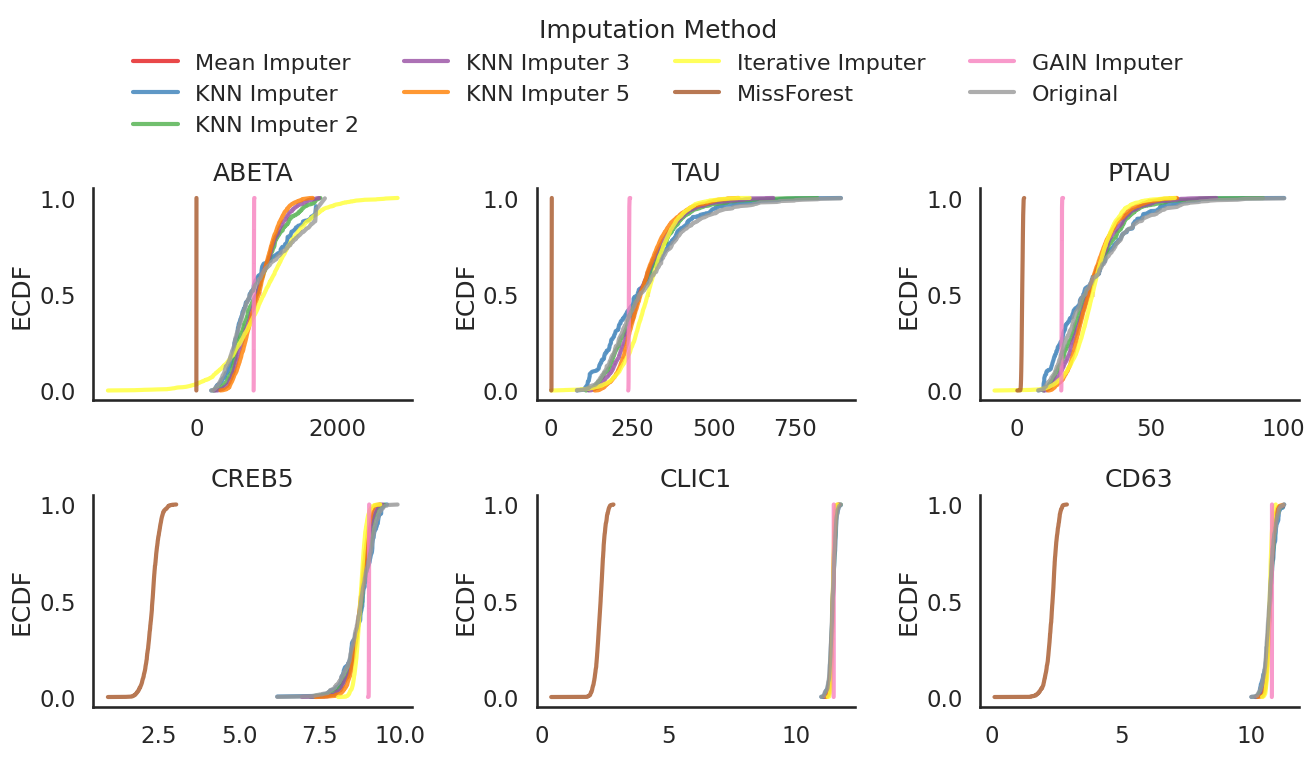

In [15]:
plot_ecdf_grid(ecdf_data_dict, features_of_interest=cols_to_check ,savefolder="../figures/imputation/ecdf")

In [16]:
# Convert results to DataFrames for heatmaps
ks_stats_df = pd.DataFrame(ks_stats).T.dropna()
p_values_df = pd.DataFrame(p_values).T.dropna()
kl_divergences_df = pd.DataFrame(kl_divs).T.dropna()
wasserstein_df = pd.DataFrame(wasserstein).T.dropna()

In [17]:
def plot_metric_heatmap(
    metric_df,
    metric_name,
    features_of_interest=None,
    annotations_df=None,
    savefolder=None,
    cmap="vlag",
    vmin=None,
    vmax=None,
    cbar_ticks=None,
    figsize=(14, 6),
    dpi=300,
    font_scale=1.2,
    annot_format_func=None,
    keys_list=None,
    full_palette=None
):
    """
    Plots a sorted, grouped heatmap with optional annotations and color grouping by modality.
    """

    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    sns.set_context("talk", font_scale=font_scale)
    sns.set_style("white")

    # Subset and sort features
    if features_of_interest is not None:
        metric_df = metric_df.loc[features_of_interest]
        if annotations_df is not None:
            annotations_df = annotations_df.loc[features_of_interest]

    # Sort columns (features) by mean metric across imputers
    feature_means = metric_df.mean(axis=0)
    sorted_features = feature_means.sort_values().index.tolist()
    metric_df = metric_df[sorted_features]
    if annotations_df is not None:
        annotations_df = annotations_df[sorted_features]

    # Create modality group colors
    if keys_list is not None and full_palette is not None:
        cat_palette = {}
        new_key_list = []
        for i, mod in enumerate(["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]):
            is_modal = [k == mod for k in keys_list]
            new_key_list.extend(np.array(keys_list)[is_modal])
            cat_palette[mod] = list(full_palette.values())[i]

        # Make sure row_colors aligns with sorted feature list
        feature_to_modality = dict(zip(keys_list, keys_list))  # keys_list is aligned with metric_df.columns
        col_colors = pd.Series(sorted_features).map(lambda x: cat_palette.get(feature_to_modality.get(x, ""), "grey"))
    else:
        col_colors = None
        cat_palette = {}

    # Format annotations
    if annotations_df is not None and annot_format_func is not None:
        annotations_df = annotations_df.applymap(annot_format_func)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    sns.heatmap(
        metric_df.transpose(),
        annot=annotations_df.transpose() if annotations_df is not None else None,
        fmt="",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="lightgrey",
        square=False,
        cbar_kws={'label': metric_name, 'ticks': cbar_ticks} if cbar_ticks else {'label': metric_name},
        ax=ax
    )

    # Clean tick labels
    ax.set_yticklabels(
        [label.get_text().replace("_", " ") for label in ax.get_yticklabels()],
        rotation=0, fontsize=11
    )
    ax.set_xticklabels(
        [label.get_text().replace("_", " ") for label in ax.get_xticklabels()],
        rotation=45, ha='right', fontsize=11
    )

    ax.set_ylabel("Imputation Method", fontsize=13)
    ax.set_xlabel("Feature", fontsize=13)

    # Add legend for group colors (feature modality)
    if col_colors is not None:
        modality_legend = [Patch(facecolor=color, label=label) for label, color in cat_palette.items()]
        ax.legend(handles=modality_legend, title="Feature Type", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()

    # Save if requested
    if savefolder is not None:
        fname = f"{savefolder}_{metric_name.lower().replace(' ', '_')}_heatmap.png"
        plt.savefig(fname, bbox_inches="tight", format="png")

    plt.show()


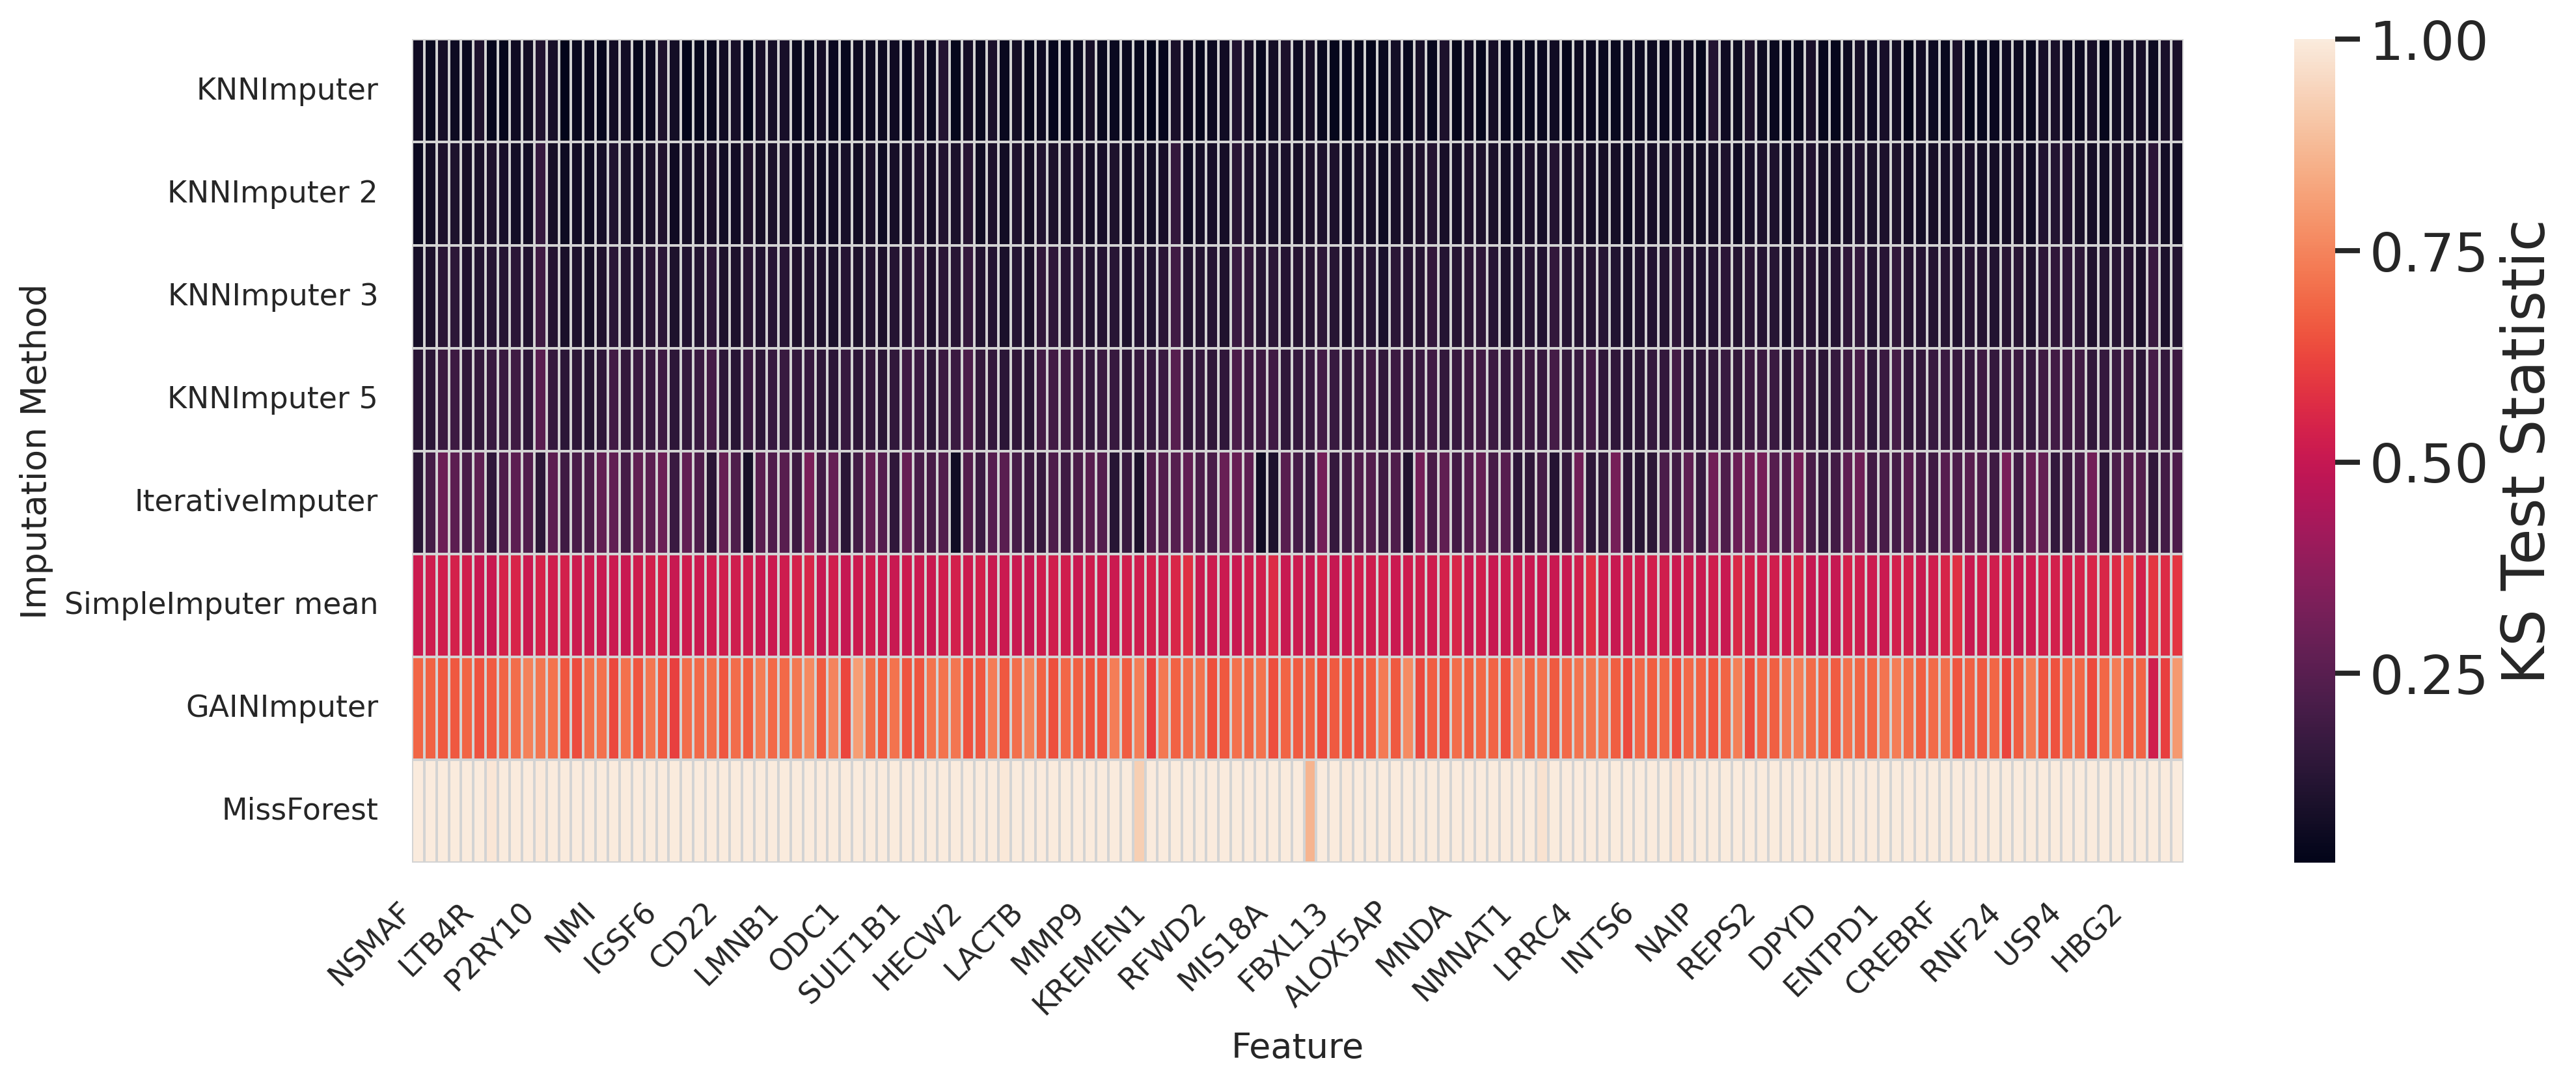

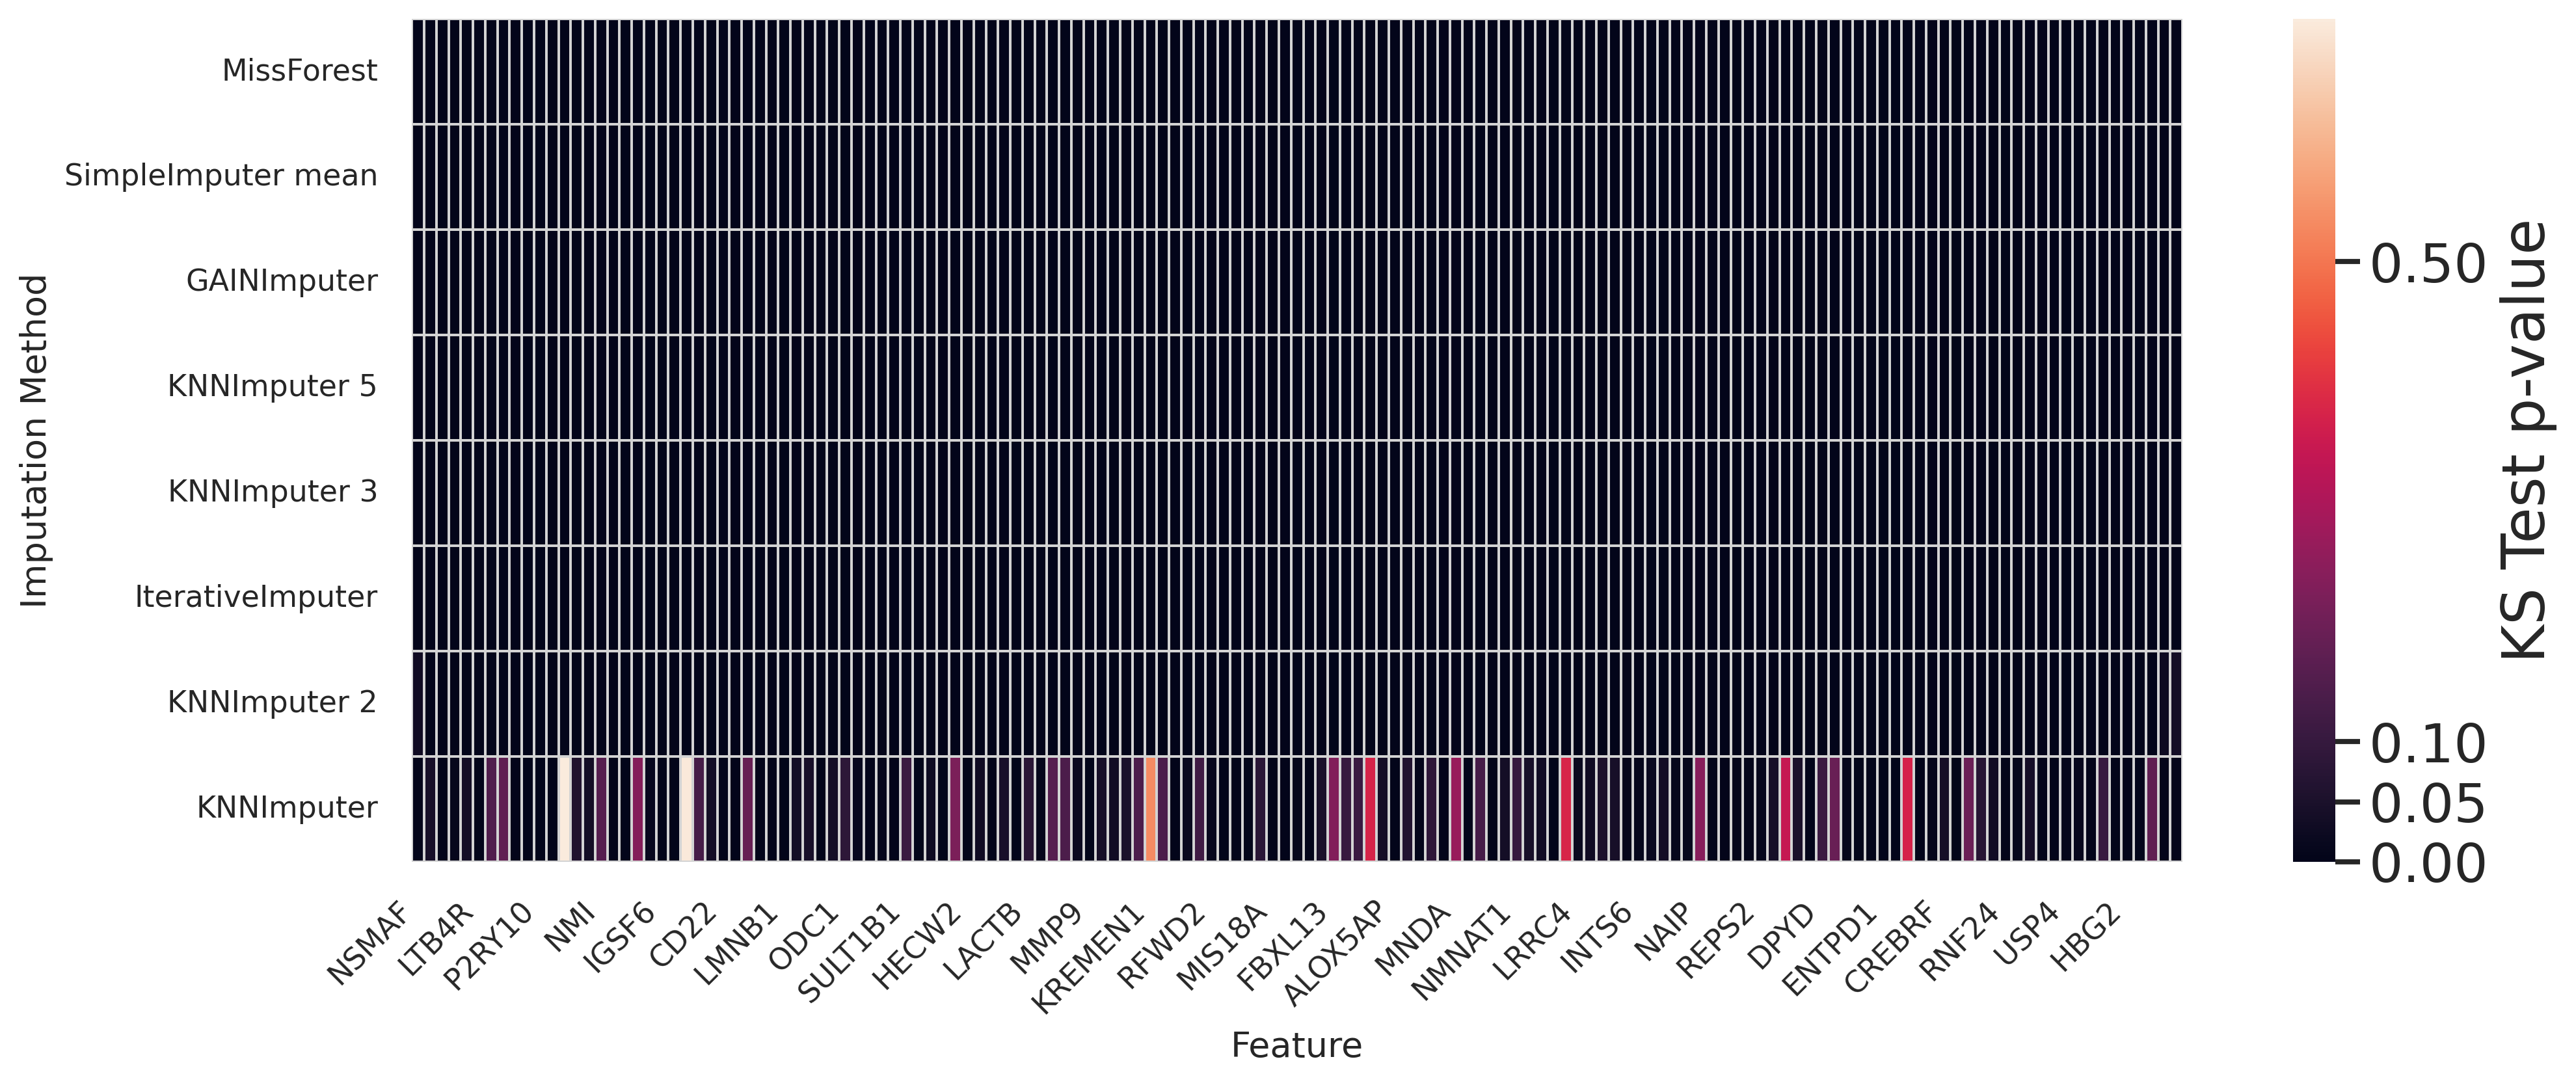

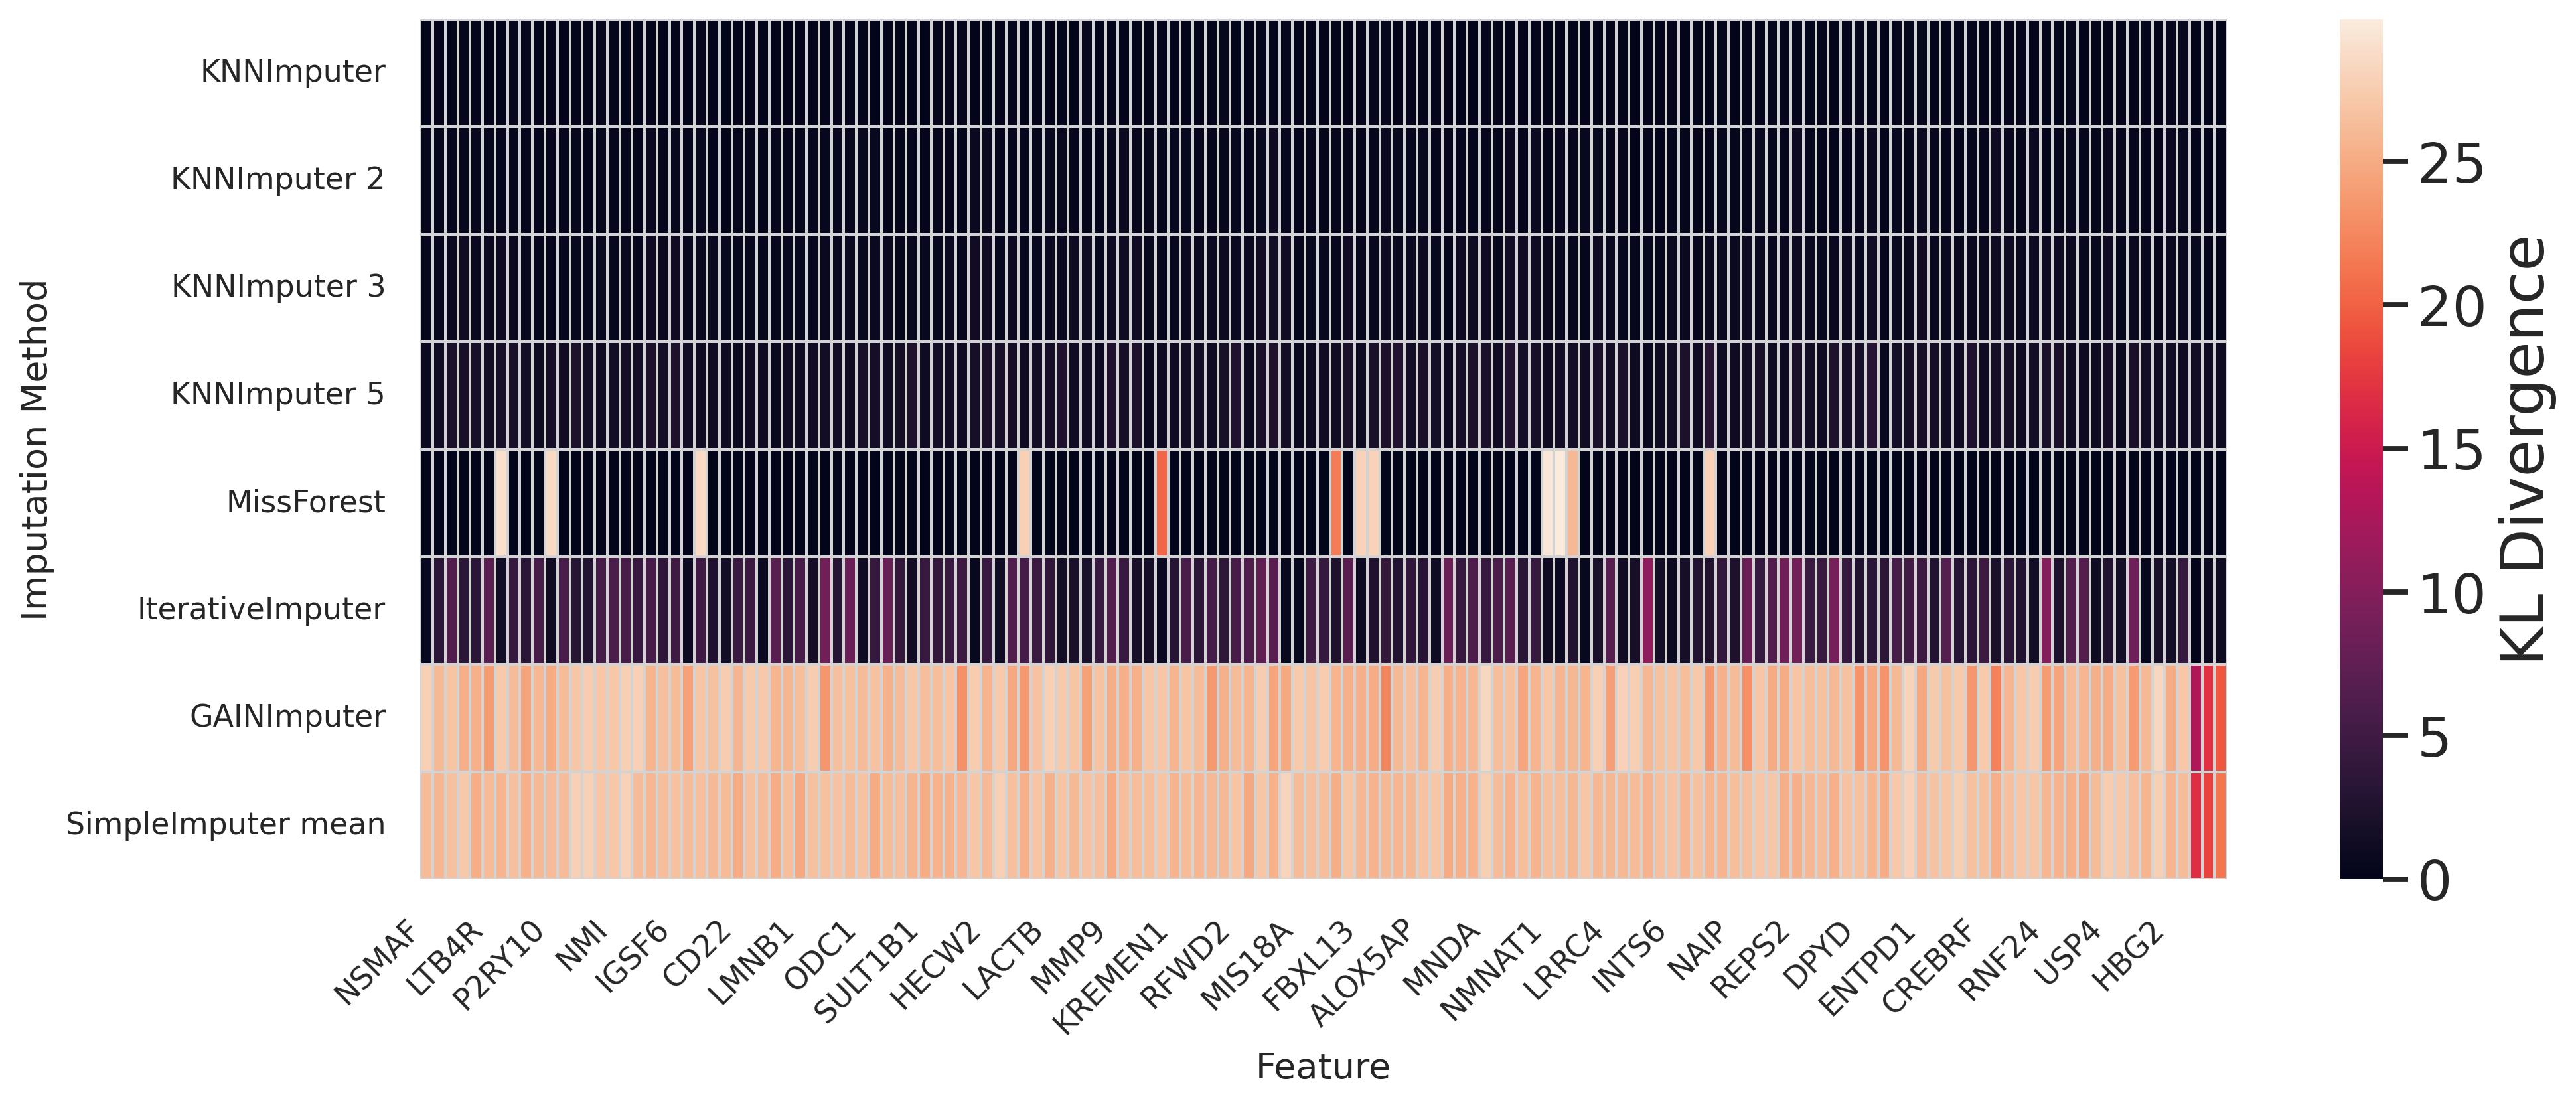

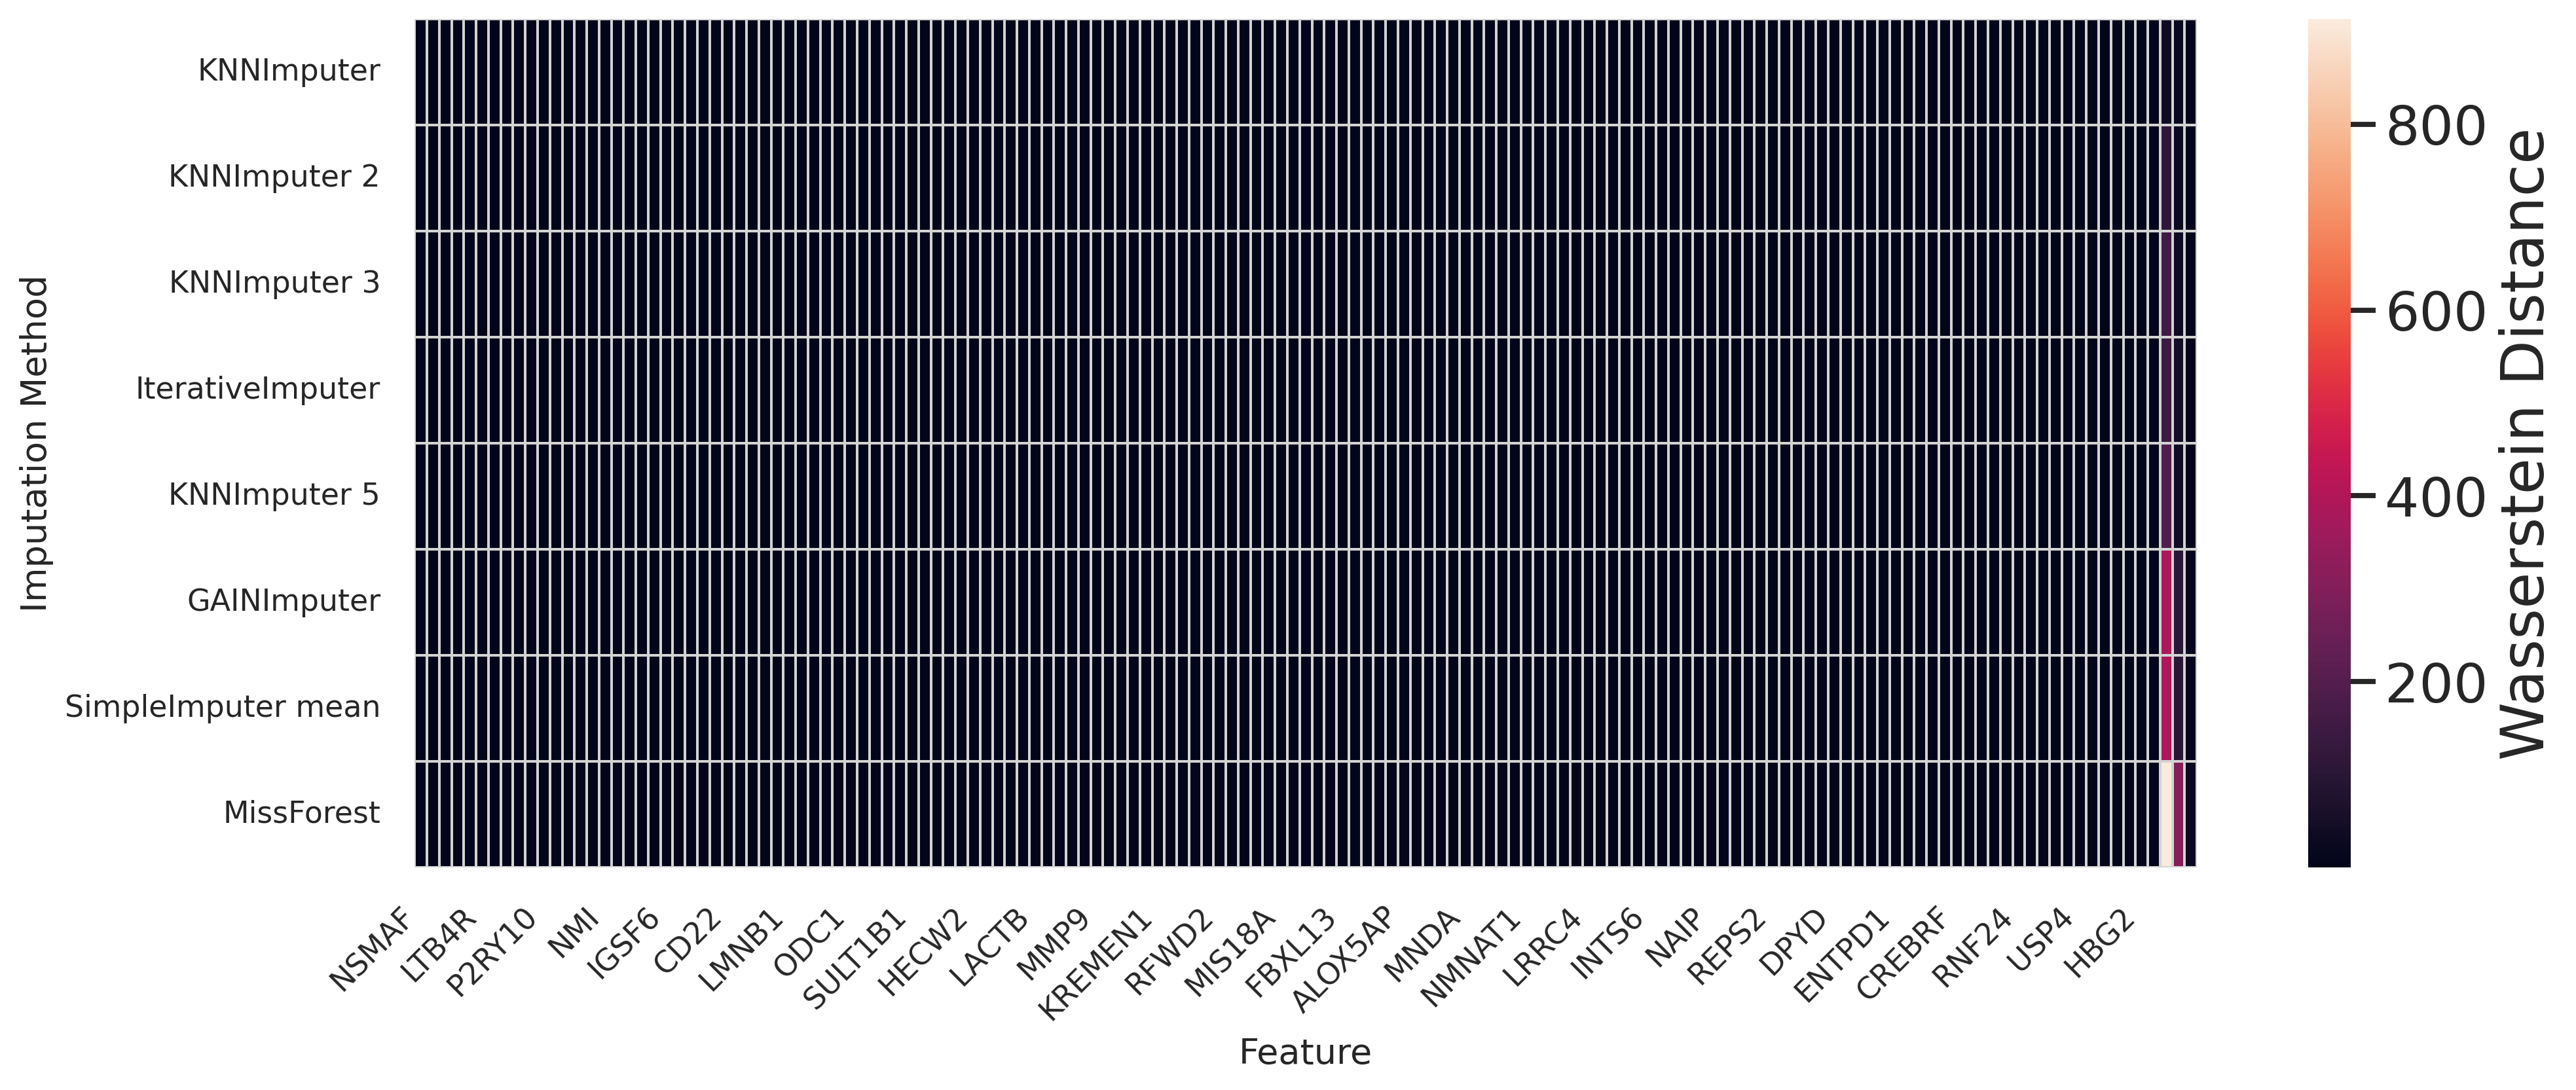

In [18]:
# KS Statistic
plot_metric_heatmap(
    metric_df=ks_stats_df,
    metric_name="KS Test Statistic",
    features_of_interest=ks_stats_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.25, 0.5, 0.75, 1.0]
)

# P-values
plot_metric_heatmap(
    metric_df=p_values_df,
    metric_name="KS Test p-value",
    features_of_interest=p_values_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
    cbar_ticks=[0.0, 0.05, 0.1, 0.5, 1.0]
)

# KL Divergence
plot_metric_heatmap(
    metric_df=kl_divergences_df,
    metric_name="KL Divergence",
    features_of_interest=kl_divergences_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

# KL Divergence
plot_metric_heatmap(
    metric_df=wasserstein_df,
    metric_name="Wasserstein Distance",
    features_of_interest=wasserstein_df.index,
    annotations_df=None,
    savefolder=savefolder,
    cmap="rocket",
)

### Order columns by KL divergence and KS test

In [19]:
def average_metrics_by_group(metric_df, feature_groups):
    """
    metric_df: pd.DataFrame, index=features, columns=imputation methods, values=metric scores
    feature_groups: dict, keys=modalities, values=list of feature names
    
    Returns:
        pd.DataFrame with modalities as rows, imputation methods as columns,
        containing average metric values per modality.
    """
    avg_dict = {}

    for group, features in feature_groups.items():
        # Only keep features actually in metric_df index
        valid_features = [f for f in features if f in metric_df.index]
        if not valid_features:
            # skip if no features in metric_df for this group
            continue

        # Compute mean of metrics for those features
        avg_metrics = metric_df.loc[valid_features].mean(axis=0)
        avg_dict[group] = avg_metrics

    # Construct DataFrame from dict of Series
    avg_df = pd.DataFrame.from_dict(avg_dict, orient='index')
    
    return avg_df

In [20]:
def average_multiple_metrics_by_group(metric_dfs, feature_groups, metric_names=None):
    """
    Averages multiple metric DataFrames across grouped features and returns a combined DataFrame
    with MultiIndex (metric name, modality) on rows.

    Parameters:
        metric_dfs (list of pd.DataFrame): Metric DataFrames with index=features and columns=methods.
        feature_groups (dict): Grouping of features per modality.
        metric_names (list of str, optional): Names corresponding to the metric_dfs. If None, will use indices.

    Returns:
        pd.DataFrame: Rows are (metric_name, modality), columns are imputation methods.
    """
    if metric_names is None:
        metric_names = [f"Metric_{i}" for i in range(len(metric_dfs))]

    combined_rows = []
    combined_index = []

    for metric_df, name in zip(metric_dfs, metric_names):
        avg_df = average_metrics_by_group(metric_df, feature_groups)
        combined_rows.append(avg_df)
        combined_index.extend([(name, idx) for idx in avg_df.index])

    # Concatenate and assign MultiIndex
    result_df = pd.concat(combined_rows)
    result_df.index = pd.MultiIndex.from_tuples(combined_index, names=["Metric", "Modality"])
    
    return result_df


In [21]:
selected_modalities = {x: dict_select[x] for x in ('RNA', 'CSF') if x in dict_select}

summary_df = average_multiple_metrics_by_group(
    metric_dfs=[ks_stats_df, p_values_df, kl_divergences_df, wasserstein_df],
    feature_groups=selected_modalities,
    metric_names=["KS-statistic", "KS-pvalue", "KL divergence", "Wasserstein distance"]
)

summary_df.T

Metric             KS-statistic                KS-pvalue                 \
Modality                    RNA       CSF            RNA            CSF   
SimpleImputer_mean     0.522049  0.581896  8.957724e-165  4.716619e-109   
KNNImputer             0.063890  0.080263   5.989306e-02   6.099821e-02   
KNNImputer_2           0.091016  0.096376   6.114214e-04   1.978099e-02   
KNNImputer_3           0.124959  0.129441   6.689534e-07   5.347243e-04   
KNNImputer_5           0.168456  0.182425   4.914505e-12   1.174249e-08   
IterativeImputer       0.220632  0.192195   1.926846e-05   2.019814e-08   
MissForest             0.998169  1.000000   0.000000e+00  4.940656e-324   
GAINImputer            0.686137  0.644770  6.246407e-251   8.231298e-95   

Metric             KL divergence            Wasserstein distance              
Modality                     RNA        CSF                  RNA         CSF  
SimpleImputer_mean     26.228093  18.769028             0.339684  169.230512  
KNNImputer              0.220768   0.076613             0.045498   19.261311  
KNNImputer_2            0.450499   0.226201             0.078506   46.857659  
KNNImputer_3            0.782107   0.484413             0.110205   63.461285  
KNNImputer_5            1.580310   1.295072             0.147361   79.263394  
IterativeImputer        4.035560   0.714108             0.198648   64.315456  
MissForest              2.034465   0.000000             5.003078  413.355697  
GAINImputer            26.014956  16.441586             0.378883  166.077472

# Select preprocessing and transforms using Linear Regression as evaluation  model

In [22]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

Some of the patients with no missing values in the test set are present in the training set so we will remove them from training. 

In [23]:
set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

In [24]:
for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [25]:
sum(idx_train) + sum(idx_test) == df_X.shape[0]

True

In [26]:
df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

In [27]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_2", KNNImputer(n_neighbors=3)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForestWrapper(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]


# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("PLSRegression_4_components", PLSRegression(n_components=4))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_4_components
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: PLSRegression_4_components
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: PLSRegression_4_components
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_4_components
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImp

In [28]:
results_file = '../pickle/training_1_imputation_check_dict_results.pickle'

In [29]:
if os. path. exists(results_file):
    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)
else : 
    all_dict_results = []

for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }

    if any(result['params'] == params for result in all_dict_results):
        # Skip this iteration if the combination exists
        print(f"Skipping existing combination: {params.values()}")
        
        continue

    try: 
        print(f"Computing combination: {params.values()}")
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    print(dict_results)
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

        # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'LinearRegression', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'PLSRegression_4_components', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'LinearRegression', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'PLSRegression_4_components', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'LinearRegression', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'PLSRegression_4_components', (2881, 348), (13, 348)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2881, 348), (13, 348)])
Skipping existing combinatio

KeyboardInterrupt: 

In [30]:
# Store data (serialize)
with open(results_file, 'wb') as handle: 
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
 with open(results_file, "rb") as input_file:
    dict_results_preprocessing = pickle.load(input_file)

In [32]:
df_results = pd.json_normalize(dict_results_preprocessing)

results_cols = df_results.columns[df_results.columns.str.startswith("results")]

In [33]:
import pandas as pd
import numpy as np

def generate_metric_table(
    results_list,
    targets,
    metric_name,
    source="Adjusted",
    float_format="%.3f",
    csv_filename=None,
    sort_order="ascending"  # or "descending"
):
    """
    Create a LaTeX table for a single metric across targets, models, and imputers.
    Optionally export the same table as CSV and sort by mean performance.

    Parameters
    ----------
    results_list : list of dict
        List of experiment results.
    targets : list of str
        Target names (e.g., ['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN']).
    metric_name : str
        Metric to extract (e.g., 'mae_score').
    source : str
        'Adjusted' or 'Original'.
    float_format : str
        Format for floats (e.g., '%.3f').
    csv_filename : str or None
        If provided, saves the table to CSV.
    sort_order : str
        'ascending' or 'descending' for sorting by mean.

    Returns
    -------
    str
        LaTeX-formatted table string.
    """
    rows = []
    version_key = "results_adj" if source.lower() == "adjusted" else "results_org"

    for res in results_list:
        result_block = res.get(version_key)
        if result_block is None:
            continue

        metric_values = result_block.get(metric_name)
        if metric_values is None:
            continue

        if len(metric_values) != len(targets):
            continue

        ordinal_imputer = res["params"].get("ordinal_imputer")
        continuous_imputer = res["params"].get("continuous_imputer")
        model = res["params"].get("model")

        values = np.array(metric_values, dtype=np.float64)
        mean_val = np.mean(values) 
        std_val = np.std(values)

        row = { 
            "Continuous Imputer" : continuous_imputer,
            "Ordinal Imputer": ordinal_imputer,
            "Model": model,
            "Mean": mean_val,  # for sorting
            "Mean ± SD": f"{mean_val:.3f} ± {std_val:.3f}",
        }
        row.update({target: val for target, val in zip(targets, values)})
        rows.append(row)

    df = pd.DataFrame(rows)

    # Reorder columns for display
    display_cols = ["Ordinal Imputer", "Continuous Imputer"] + targets + ["Mean ± SD"]
    df = df.sort_values(by="Mean", ascending=(sort_order == "ascending"))
    df = df[display_cols]

    # Save CSV
    if csv_filename:
        df.to_csv(csv_filename, index=False)

    # LaTeX output
    latex_table = df.to_latex(
        index=False,
        escape=False,
        float_format=float_format,
        caption=f"{metric_name.replace('_', ' ').upper()} across targets",
        label=f"tab:{metric_name}",
        longtable=False
    )

    return df, latex_table

In [34]:
dict_results_preprocessing

[{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent',
   'continuous_imputer': 'SimpleImputer_mean',
   'model': 'LinearRegression',
   'train_shape': (2881, 348),
   'test_shape': (13, 348)},
  'imputation_time': 0.012824058532714844,
  'fitting_time': 0.13628268241882324,
  'results_adj': {'mse_score': array([0.83082988, 0.55120855, 0.45176276, 0.72817279]),
   'mae_score': array([0.76806924, 0.50765242, 0.5505181 , 0.71713299]),
   'r2': array([0.16029857, 0.37452134, 0.05674317, 0.1142355 ]),
   'explained_variance': array([0.16689222, 0.38376848, 0.06952129, 0.22565781]),
   'corr': array([0.55465032, 0.69286545, 0.442099  , 0.55378286])},
  'results_org': {'mse_score': array([0.83082986, 0.55120853, 0.45176277, 0.72817277]),
   'mae_score': array([0.76806924, 0.50765243, 0.55051811, 0.71713299]),
   'r2': array([0.11621113, 0.38249433, 0.12010971, 0.14862643]),
   'explained_variance': array([0.12315097, 0.3916236 , 0.13202942, 0.25572263]),
   'corr': array([0.53131009,

In [35]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='corr',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_corr_adjusted_sorted.csv",
    sort_order="descending"
)
print(latex_mae)

\begin{table}
\caption{CORR across targets}
\label{tab:corr}
\begin{tabular}{llrrrrl}
\toprule
Ordinal Imputer & Continuous Imputer & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD \\
\midrule
SimpleImputer_constant & MissForest & 0.686 & 0.777 & 0.492 & 0.614 & 0.642 ± 0.104 \\
SimpleImputer_most_frequent & MissForest & 0.682 & 0.779 & 0.494 & 0.614 & 0.642 ± 0.104 \\
KNNImputer & MissForest & 0.683 & 0.778 & 0.491 & 0.614 & 0.641 ± 0.105 \\
SimpleImputer_most_frequent & KNNImputer & 0.606 & 0.692 & 0.402 & 0.666 & 0.592 ± 0.114 \\
KNNImputer & KNNImputer & 0.588 & 0.689 & 0.410 & 0.665 & 0.588 ± 0.109 \\
SimpleImputer_constant & KNNImputer & 0.581 & 0.684 & 0.405 & 0.653 & 0.581 ± 0.108 \\
SimpleImputer_most_frequent & KNNImputer_5 & 0.594 & 0.723 & 0.488 & 0.504 & 0.577 ± 0.093 \\
SimpleImputer_most_frequent & KNNImputer_2 & 0.581 & 0.736 & 0.429 & 0.561 & 0.577 ± 0.109 \\
KNNImputer & KNNImputer_5 & 0.582 & 0.719 & 0.494 & 0.503 & 0.574 ± 0.090 \\
KNNImputer & KNNImputer_2 & 0

In [36]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='r2',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_r2_adjusted_sorted.csv",
    sort_order="descending"
)
print(latex_mae)

\begin{table}
\caption{R2 across targets}
\label{tab:r2}
\begin{tabular}{llrrrrl}
\toprule
Ordinal Imputer & Continuous Imputer & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD \\
\midrule
SimpleImputer_most_frequent & KNNImputer & 0.333 & 0.444 & 0.145 & 0.310 & 0.308 ± 0.107 \\
KNNImputer & KNNImputer & 0.311 & 0.440 & 0.151 & 0.309 & 0.303 ± 0.103 \\
SimpleImputer_constant & KNNImputer & 0.309 & 0.437 & 0.146 & 0.314 & 0.302 ± 0.103 \\
SimpleImputer_most_frequent & KNNImputer_2 & 0.290 & 0.489 & 0.163 & 0.168 & 0.277 ± 0.132 \\
SimpleImputer_constant & KNNImputer_2 & 0.272 & 0.484 & 0.165 & 0.182 & 0.276 ± 0.127 \\
KNNImputer & KNNImputer_2 & 0.274 & 0.485 & 0.166 & 0.168 & 0.273 ± 0.130 \\
SimpleImputer_most_frequent & KNNImputer_5 & 0.308 & 0.456 & 0.217 & 0.090 & 0.268 ± 0.134 \\
KNNImputer & KNNImputer_5 & 0.293 & 0.451 & 0.220 & 0.089 & 0.263 ± 0.130 \\
SimpleImputer_constant & KNNImputer_5 & 0.286 & 0.449 & 0.219 & 0.095 & 0.262 ± 0.128 \\
SimpleImputer_most_frequent & GA

In [37]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='mse_score',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_mae_adjusted_sorted.csv",
    sort_order="ascending"
)
print(latex_mae)

\begin{table}
\caption{MSE SCORE across targets}
\label{tab:mse_score}
\begin{tabular}{llrrrrl}
\toprule
Ordinal Imputer & Continuous Imputer & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD \\
\midrule
SimpleImputer_most_frequent & KNNImputer & 0.660 & 0.490 & 0.410 & 0.567 & 0.531 ± 0.093 \\
KNNImputer & KNNImputer & 0.681 & 0.494 & 0.407 & 0.568 & 0.538 ± 0.101 \\
SimpleImputer_constant & KNNImputer & 0.684 & 0.497 & 0.409 & 0.564 & 0.538 ± 0.100 \\
SimpleImputer_most_frequent & KNNImputer_2 & 0.703 & 0.450 & 0.401 & 0.684 & 0.559 ± 0.135 \\
SimpleImputer_constant & KNNImputer_2 & 0.720 & 0.454 & 0.400 & 0.673 & 0.562 ± 0.137 \\
KNNImputer & KNNImputer_2 & 0.719 & 0.454 & 0.399 & 0.684 & 0.564 ± 0.139 \\
SimpleImputer_most_frequent & KNNImputer_5 & 0.684 & 0.479 & 0.375 & 0.748 & 0.572 ± 0.151 \\
KNNImputer & KNNImputer_5 & 0.700 & 0.484 & 0.374 & 0.749 & 0.577 ± 0.154 \\
SimpleImputer_constant & KNNImputer_5 & 0.707 & 0.485 & 0.374 & 0.744 & 0.578 ± 0.154 \\
SimpleImputer_most

In [38]:
latex_df, latex_mae = generate_metric_table(
    results_list=dict_results_preprocessing,
    targets=['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'],
    metric_name='mae_score',
    source="Adjusted",
    csv_filename="../tables/1_training_imputation_mae_adjusted_sorted.csv",
    sort_order="ascending"
)
print(latex_mae)

\begin{table}
\caption{MAE SCORE across targets}
\label{tab:mae_score}
\begin{tabular}{llrrrrl}
\toprule
Ordinal Imputer & Continuous Imputer & ADNI_MEM & ADNI_EF & ADNI_VS & ADNI_LAN & Mean ± SD \\
\midrule
SimpleImputer_most_frequent & KNNImputer & 0.640 & 0.551 & 0.565 & 0.600 & 0.589 ± 0.034 \\
KNNImputer & KNNImputer & 0.649 & 0.556 & 0.563 & 0.601 & 0.592 ± 0.037 \\
SimpleImputer_constant & KNNImputer & 0.659 & 0.559 & 0.566 & 0.603 & 0.597 ± 0.040 \\
SimpleImputer_most_frequent & KNNImputer_2 & 0.666 & 0.518 & 0.560 & 0.684 & 0.607 ± 0.070 \\
KNNImputer & KNNImputer_2 & 0.673 & 0.523 & 0.557 & 0.684 & 0.609 ± 0.070 \\
SimpleImputer_constant & KNNImputer_2 & 0.684 & 0.525 & 0.559 & 0.682 & 0.613 ± 0.071 \\
SimpleImputer_most_frequent & KNNImputer_5 & 0.704 & 0.519 & 0.526 & 0.728 & 0.619 ± 0.097 \\
KNNImputer & KNNImputer_5 & 0.711 & 0.525 & 0.528 & 0.728 & 0.623 ± 0.097 \\
SimpleImputer_constant & KNNImputer_5 & 0.722 & 0.529 & 0.529 & 0.730 & 0.627 ± 0.099 \\
SimpleImputer_most